In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import time
import sklearn
from sklearn import metrics

#import functions as fn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculateReturns(prices, lag):
    
    #prices is a pandasDataFrame type
    prevPrices = prices.shift(lag)
    return ((prices - prevPrices) / prevPrices)

def thresh_func(x, lb, ub):
    
    if x <= lb:
        return 0
    elif lb < x < ub:
        return 1
    
    elif x > ub:
        return 2
    
    else:
        return np.nan

In [3]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(5,5))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets)))
    plt.yticks(list(range(num_targets)))

In [4]:
def plots(MLmodel, MLtype):

    df=pd.read_csv("XLU.csv")
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=["PERMNO","date"], inplace=True)
    
    df["price"]=(df.ASK+df.BID)/2
    df["bidAskSpread"]=df.ASK-df.BID
    df["marketValue"] = df.SHROUT*df.price
    df["dollarVolume"] = df.VOL*df.price
    
    df["RET_1Mo"] = np.where(df.PERMNO == df.PERMNO.shift(21), (df.price-df.price.shift(21))/df.price.shift(21), np.nan)
    df["RET_3Mo"]  = np.where(df.PERMNO == df.PERMNO.shift(63), (df.price-df.price.shift(63))/df.price.shift(63), np.nan)
    df["RET_12Mo"]  = np.where(df.PERMNO == df.PERMNO.shift(253), (df.price-df.price.shift(253))/df.price.shift(253), np.nan)
    

    df["VolRET"] = np.where(df.PERMNO == df.PERMNO.shift(63), df.RET.rolling(window=63).std()*np.sqrt(253), np.nan)
   
    df["StdRET_12Mo"]=np.where(df.PERMNO == df.PERMNO.shift(253), df.RET.rolling(window=253).std(), np.nan)
    df["StdMARKET_12Mo"]=np.where(df.PERMNO == df.PERMNO.shift(253), df.sprtrn.rolling(window=253).std(), np.nan)
    df["CovRETMARKET_12Mo"]=np.where(df.PERMNO == df.PERMNO.shift(253),df.RET.rolling(window=253).cov(df.sprtrn.rolling(window=253)), np.nan)
    
    df["Beta_12Mo"]=df.CovRETMARKET_12Mo/(df.StdMARKET_12Mo**2)
    df["IvolRET_12Mo"]=np.sqrt((df.StdRET_12Mo**2-(df.Beta_12Mo*df.StdMARKET_12Mo)**2))*np.sqrt(253)
    df["BetaSq_12Mo"]=df.Beta_12Mo**2

    df["StdRET_3Mo"]=np.where(df.PERMNO == df.PERMNO.shift(63), df.RET.rolling(window=63).std(), np.nan)
    df["StdMARKET_3Mo"]=np.where(df.PERMNO == df.PERMNO.shift(63), df.sprtrn.rolling(window=63).std(), np.nan)
    df["CovRETMARKET_3Mo"]=np.where(df.PERMNO == df.PERMNO.shift(63),df.RET.rolling(window=63).cov(df.sprtrn.rolling(window=63)), np.nan)
    df["Beta_3Mo"]=df.CovRETMARKET_3Mo/(df.StdMARKET_3Mo**2)
    df["IvolRET_3Mo"]=np.sqrt((df.StdRET_3Mo**2-(df.Beta_3Mo*df.StdMARKET_3Mo)**2))*np.sqrt(253)
    df["BetaSq_3Mo"]=df.Beta_3Mo**2
    
    dfprice = df.price
    dfprice.index = df.date
    dfprice.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
    
    df.drop(['PERMNO', 'date','PRC','BID','ASK', 'price'], axis=1, inplace=True)

    dates = dfprice.index
    #df_list = df_list
    mid = dfprice

    #holdingDays = 252 // 4; #hold a quarter
    holdingDays = 100
    #Returns
    Ret1 = calculateReturns(mid.copy(), 1).fillna(value=0)
    #20 week return
    RetQ = calculateReturns(mid.copy(), holdingDays) 

    #shifted next quarter's return to today's row to use as response variable. 
    #Can enter only at next day's close. 
    RetFut = RetQ.copy().shift(-(holdingDays+1))

    trainSize = 2516
    
    #flattening and repetition of the date vector
    flat_train = RetFut[:trainSize].size
    flat_test = RetFut[trainSize:].size
    flat = RetFut.size
    m0 = RetFut.shape[0] #original number of observations
    #nStocks = RetFut.shape[1] #original number of stocks

    datesTrain = dates.values[:trainSize].flatten()
    datesTest = dates.values[trainSize:].flatten()
    
    if MLtype == 'regression':
        Y0train = RetFut.values[:trainSize].flatten()[:,np.newaxis]
        Y0test = RetFut.values[trainSize:].flatten()[:,np.newaxis]
        
    elif MLtype == 'classification':
        a = RetFut.values
        lb = np.nanpercentile(a, 33)
        ub = np.nanpercentile(a, 66)
        Y = []
        for ret in RetFut:
            ret = thresh_func(ret, lb, ub)
            Y.append(ret)
        Yarray = np.array(Y).reshape(len(Y),1)
        Y0train = Yarray[:trainSize].flatten()[:,np.newaxis]
        Y0test = Yarray[trainSize:].flatten()[:,np.newaxis]
    
    #number of features - there are 23 features in total
    nInd = df.shape[1]
    
    X0train = np.zeros((flat_train, nInd))
    X0test = np.zeros((flat_test, nInd))
    X0 = np.zeros((flat, nInd))
    
    #######################
    #n = 0
    #df = df.values
    #X0train[:, n] = df[:trainSize].flatten()
    #X0test[:, n] = df[trainSize:].flatten()
    
    X0train = df.values[:trainSize]#.flatten()[:,np.newaxis]
    X0test = df.values[trainSize:]#.flatten()[:,np.newaxis]
    ########################
    
    dataCleanTrain = pd.DataFrame(np.hstack([X0train, Y0train]))
    dataCleanTrain.index = datesTrain
    
    dataCleanTest = pd.DataFrame(np.hstack([X0test, Y0test]))
    dataCleanTest.index = datesTest
    
    dataCleanTrain.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
    dataCleanTest.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
    
    dataCleanTrain.dropna(how='any', axis=0, inplace=True)
    dataCleanTest.dropna(how='any', axis=0, inplace=True)
    
    ixCleanTrain = dataCleanTrain.index.values
    ixCleanTest = dataCleanTest.index.values
    #print("First training day: {}".format(ixCleanTrain[0]))
    #print("Last training day: {}".format(ixCleanTrain[-1]))
    #print("First testing day: {}".format(ixCleanTest[0]))
    #print("Last testing day: {}".format(ixCleanTest[-1]))

    dataCleanTrain = dataCleanTrain.values
    dataCleanTest = dataCleanTest.values

    Xtrain, ytrain = dataCleanTrain[:, 0:-1], dataCleanTrain[:, -1][:,np.newaxis]
    Xtest, ytest = dataCleanTest[:, 0:-1], dataCleanTest[:, -1][:,np.newaxis]

    print(MLmodel)
    print(MLtype)

    filename = MLmodel + '-' + MLtype + '-ETF-predictions.csv'
    filename2 = MLmodel + '-' + MLtype + '-ETF-train-predictions.csv'
    
    df1 = pd.read_csv(filename2, index_col=0)
    df2 = pd.read_csv(filename, index_col=0)
    df3 = df1.append(df2)

    df4 = pd.DataFrame(df3.XLU)
    df4['actual'] = ytrain

    df4.index = ixCleanTrain

    title = "XLU " + MLmodel + " " + MLtype + " Results"

    fig = plt.figure(figsize=(15,8))
    fig.add_subplot(1,1,1)
    plt.plot(df4)
    plt.title(title) 
    plt.xlabel("Year") 
    plt.ylabel("Return")
    p = mpatches.Patch(color='orange', label='Predicted')
    a = mpatches.Patch(color='blue', label='Actual')
    plt.legend(handles=[p,a])

    #if MLtype == 'classification':
      #from sklearn.metrics import confusion_matrix
      #y_true = df4.actual
      #y_pred = df4.XLU
      #cm = confusion_matrix(y_true, y_pred)
      #plot_confusion_matrix(cm)
    

rf
regression
rf
classification
svm
regression
svm
classification
gb
regression
gb
classification


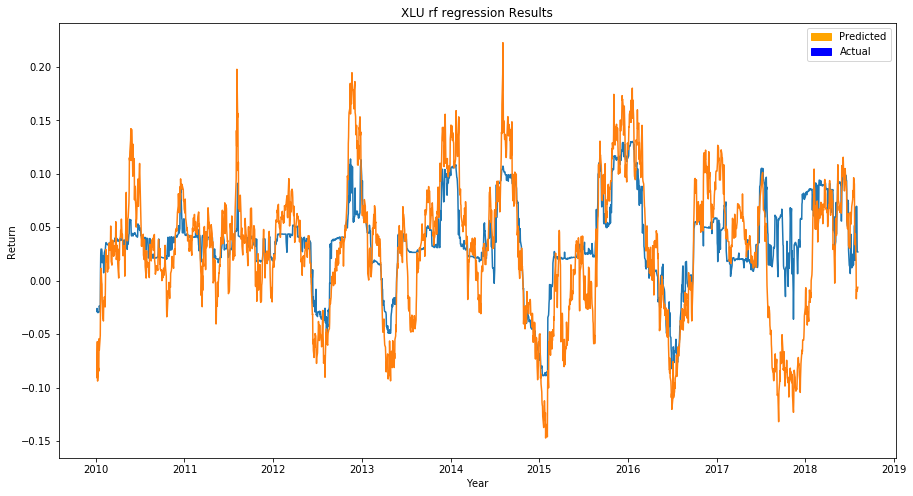

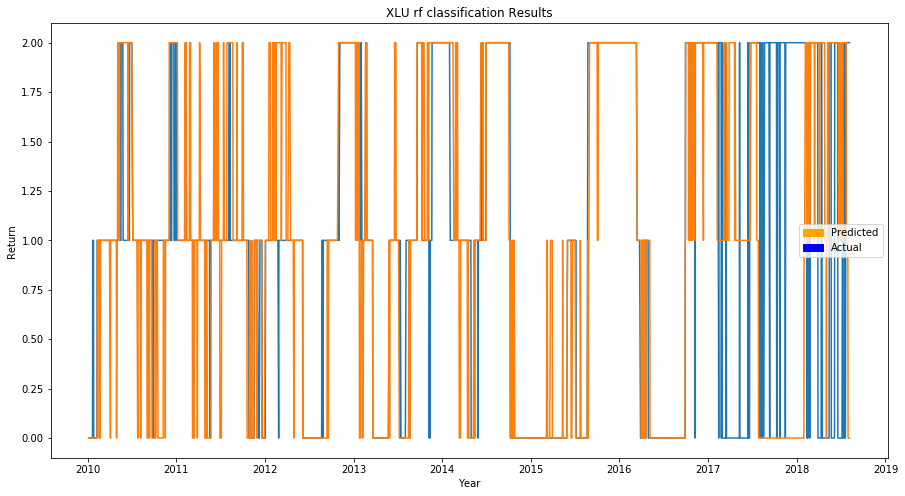

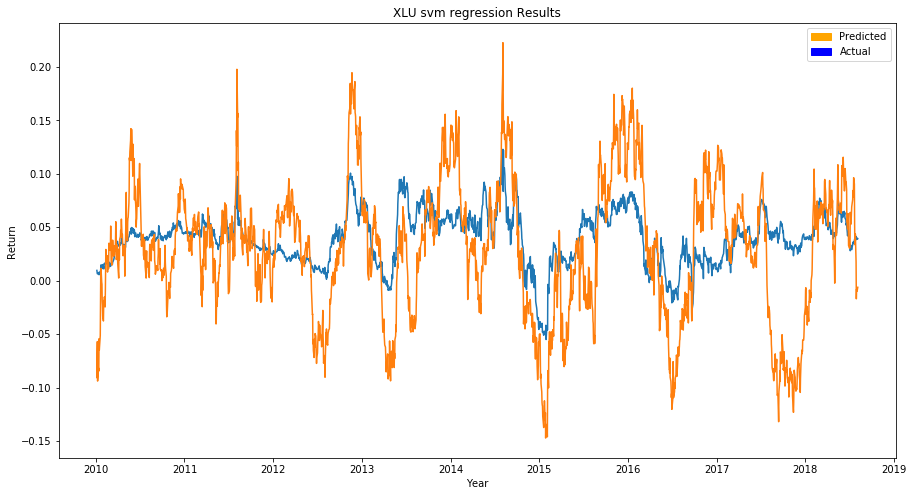

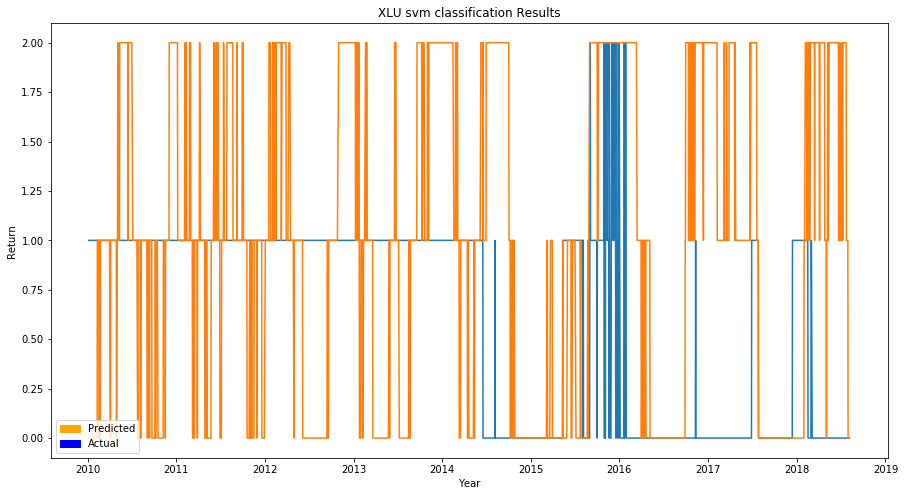

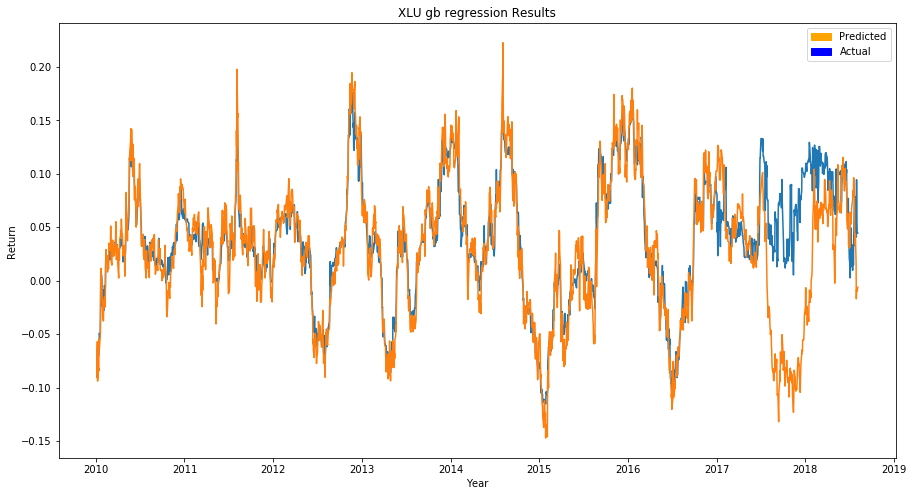

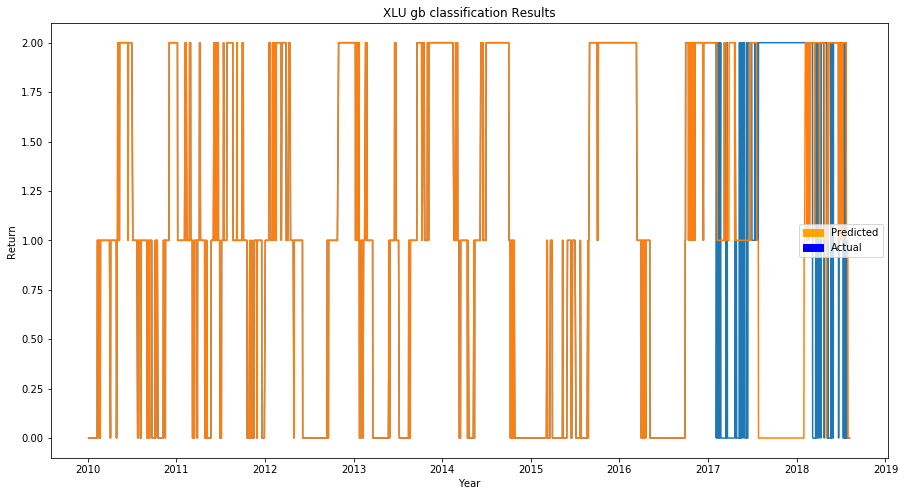

In [6]:
#df1 = pd.read_csv("rf-regression-ETF-train-predictions.csv", index_col=0)

MLmodel = ['rf', 'svm', 'gb']
MLtype = ['regression','classification']

for model in MLmodel:
  for t in MLtype:
    plots(model, t)